<a href="https://colab.research.google.com/github/augustolnb/IA-projects/blob/main/metric_learning_working-v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Libraries and paths

In [1]:
!pip install gitpython
!pip install tensorflow
!pip install opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 5.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 42.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.2
    Uninstalling numpy-1.24.2:
      Successfully uninstalled numpy-1.24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
orbax 0.1.7 requires jax>=0.4.6, but you have jax 0.3.25 which is incompatible.
flax 0.6.8 requires jax>=0.4.2, but you have jax 0.3.25 which is incompatible.
chex 0.1.7 requires jax>=0.4.6, but you have jax 0.3.25 which is incompatib

In [2]:
# Bibliotecas
import os
import cv2
import git
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# Módulos tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import resnet
from keras.optimizers import Adam

In [3]:
# Clona ds
git.Repo.clone_from("https://github.com/augustolnb/datasets.git", "/content/dataset")

# Caminho da pasta raiz contendo as subpastas do ds
dataset = "/content/dataset/faces_img_ds"


###Processing images - *MapFunction()*

In [4]:
# tentar retirar MapFuncion
class MapFunction():
	def __init__(self, imageSize):
		# define the image width and height
		self.imageSize = imageSize
	def decode_and_resize(self, imagePath):
		# read and decode the image path
		image = tf.io.read_file(imagePath)
		image = tf.image.decode_jpeg(image, channels=3)
		# convert the image data type from uint8 to float32 and then resize
		# the image to the set image size
		image = tf.image.convert_image_dtype(image, dtype=tf.float32)
		image = tf.image.resize(image, self.imageSize)
		# return the image
		return image
	def __call__(self, anchor, positive, negative):
		anchor = self.decode_and_resize(anchor)
		positive = self.decode_and_resize(positive)
		negative = self.decode_and_resize(negative)
		# return the anchor, positive and negative processed images
		return (anchor, positive, negative)

###Labels, dict and img_generator - *TripletGenerator*

In [5]:
# Rotula dataset
labels = []
obj = os.scandir(dataset)

for dir in obj:     # Percorre diretorio
    if dir.is_dir() == True:
        foldername = dir.name   # Captura nome da pasta
        count_files = len(os.listdir("/content/dataset/faces_img_ds/"+foldername))  # Captura numero de imagens na pasta
        if count_files == 1:    # Se houve apenas uma imagem da pasta, pula para proxima iteração
#            print(count_files)
            continue
#        for i in range(count_files): # Anexa o nome da subpasta na lista count_files vezes ex: 7 imagens na subpasta gera 7 nomes iguais na lista
        labels.append(os.path.join("/content/dataset/faces_img_ds/", foldername))
        
labels = sorted(labels, key = lambda s: s.casefold())
labels = np.array(labels)

# Define numero de pessoas no dataset
n_classes = len(labels)

print(n_classes) 

2984


In [6]:
# Cria dicionário dict_names[person_name] = [lista_imagens]
dict_names = dict()

for person_name in labels:
    person_photos = []
    image_names = os.listdir(person_name)
    for img_name in image_names:
        img_name = img_name.decode()
        person_photos.append(os.path.join(person_name, img_name))

    dict_names[person_name] = person_photos

print((dict_names))

{'/content/dataset/faces_img_ds/Aaron_Eckhart': ['/content/dataset/faces_img_ds/Aaron_Eckhart/Aaron_Eckhart_0002_0002.jpg', '/content/dataset/faces_img_ds/Aaron_Eckhart/Aaron_Eckhart_0002_0001.jpg', '/content/dataset/faces_img_ds/Aaron_Eckhart/Aaron_Eckhart_0002_0000.jpg', '/content/dataset/faces_img_ds/Aaron_Eckhart/Aaron_Eckhart_0001_0001.jpg', '/content/dataset/faces_img_ds/Aaron_Eckhart/Aaron_Eckhart_0001_0000.jpg', '/content/dataset/faces_img_ds/Aaron_Eckhart/Aaron_Eckhart_0001_0002.jpg'], '/content/dataset/faces_img_ds/Aaron_Guiel': ['/content/dataset/faces_img_ds/Aaron_Guiel/Aaron_Guiel_0002_0000.jpg', '/content/dataset/faces_img_ds/Aaron_Guiel/Aaron_Guiel_0001_0000.jpg'], '/content/dataset/faces_img_ds/Aaron_Peirsol': ['/content/dataset/faces_img_ds/Aaron_Peirsol/Aaron_Peirsol_0003_0002.jpg', '/content/dataset/faces_img_ds/Aaron_Peirsol/Aaron_Peirsol_0001_0002.jpg', '/content/dataset/faces_img_ds/Aaron_Peirsol/Aaron_Peirsol_0003_0000.jpg', '/content/dataset/faces_img_ds/Aaron_P

In [7]:
def img_generator(): # get_next_element()

    while True:
        # sorteia aleatoriamente uma classe para ser a ancora e imagem positiva
        anchor_name = np.random.choice(labels)

        # Cria uma cópia temporária da lista de nomes para garantir que a imagem negativa seja de outra classe
        temp_names = dict_names.copy()
        #temp_names.remove(anchor_name)

        # sorteia aleatoriamente a classe da imagem negativa
        negative_name = np.random.choice(labels)

        # seleciona 2 imagens da classe ancora
        (anchor_photo, positive_photo) = np.random.choice(
            a=dict_names[anchor_name],
            size=2,
            replace=False
        )

        # seleciona imagem da classe negativa
        negative_photo = np.random.choice(dict_names[negative_name])
        yield (anchor_photo, positive_photo, negative_photo)

###Definição do modelo encapsulado - *get_embedding_module*

In [8]:
# Modelo encapsulado composto por uma camada de entrada que recebe as imagens 112x112x3
# em conjunto com uma rede pré treinada (ResNet50), que utilizando algumas camadas e os
# pesos pré definidos faz a extração das features das imagens de entrada.
# Após extrair as features é feito o acoplamento com camadas mais baixas para regularização,
# normalização e geração de uma saída.

def encapsulated_model(image_size):

    # camada de entrada do modelo
    input_img = keras.Input(image_size + (3,))
    x = resnet.preprocess_input(input_img)

    # rede pré treinada, usada para extrair as características das imagens    
    pretreined_model = resnet.ResNet50(weights="imagenet", include_top=False)
    pretreined_model.trainable=False
    
    # extração das features pela ResNet50
    extractedFeatures = pretreined_model(x)

    # camadas inferiores do modelo
    # compacta a saida de ResNet50
    x = layers.GlobalAveragePooling2D()(extractedFeatures)
    x = layers.Dense(units=1024, activation="relu")(x)
    # primeira camada de regularização 
    x = layers.Dropout(0.2)(x)
    # primeira camada de normalização
    x = layers.BatchNormalization()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    # segunda camada de regularização 
    x = layers.Dropout(0.2)(x)
    # segunda camada de normalização
    x = layers.BatchNormalization()(x)
    x = layers.Dense(units=256, activation="relu")(x)
    # terceira camada de regularização 
    x = layers.Dropout(0.2)(x)
    vetor_descritor = layers.Dense(units=128)(x)

    model_encapsulado = keras.Model(input_img, vetor_descritor, name="model_encapsulado")

    return model_encapsulado

###Gerar Triplet Net - *get_siamese_network*

In [9]:
def triplet_network(image_size, encap_model):
    # build the anchor, positive and negative input layer
    anchor_input = keras.Input(name="anchor", shape=image_size + (3,))
    positive_input = keras.Input(name="positive", shape=image_size + (3,))
    negative_input = keras.Input(name="negative", shape=image_size + (3,))
    # embed the anchor, positive and negative images
    encap_anchor = encap_model(anchor_input)
    encap_positive = encap_model(positive_input)
    encap_negative = encap_model(negative_input)
    # build the triplet network and return it
    tri_network = keras.Model(
        inputs=[anchor_input, positive_input, negative_input],
        outputs=[encap_anchor, encap_positive, encap_negative]
    )
    inputs=[anchor_input, positive_input, negative_input]
    outputs=[encap_anchor, encap_positive, encap_negative]
    
    return tri_network, inputs, outputs

###Definição da classe do modelo - *SiameseModel()*

In [10]:
class Triplet_model(keras.Model):
    def __init__(self, triplet_net, margin, lossTracker):
        super().__init__()
        self.triplet_net = triplet_net
        self.margin = margin
        self.lossTracker = lossTracker
    
      
    def call(self, inputs):
        (apDistance, anDistance) = self._compute_distance(inputs)

        return (apDistance, anDistance)

    def _compute_distance(self, inputs): # Distância euclidiana
        (anchor, positive, negative) = inputs
        encapsulamento = self.triplet_net((anchor, positive, negative))

        # vetores descritores
        encap_anchor = encapsulamento[0]
        encap_positive = encapsulamento[1]
        encap_negative = encapsulamento[2]

        # calcula distância entre os descritores
        apDistance = tf.reduce_sum(tf.square(encap_anchor - encap_positive), axis=-1)
        anDistance = tf.reduce_sum(tf.square(encap_anchor - encap_negative), axis=-1)

        return (apDistance, anDistance)
   
   # função para calcular a perda triplet.
    def _compute_loss(self, apDistance, anDistance):
        loss = apDistance - anDistance
        loss = tf.maximum(loss + self.margin, 0.0)

        return loss

    #função call aqui

    def train_step(self, inputs):
        with tf.GradientTape() as tape:
            (apDistance, anDistance) = self._compute_distance(inputs)
            loss = self._compute_loss(apDistance, anDistance)
        gradients = tape.gradient(
            loss,
            self.triplet_net.trainable_variables)
        self.optimizer.apply_gradients(
            zip(gradients, self.triplet_net.trainable_variables)
        )
        self.lossTracker.update_state(loss)

        return {"loss": self.lossTracker.result()}
   
    def test_step(self, inputs):
        (apDistance, anDistance) = self._compute_distance(inputs)
        loss = self._compute_loss(apDistance, anDistance)
        self.lossTracker.update_state(loss)

        return {"loss": self.lossTracker.result()}
    @property
    def metrics(self):
        return [self.lossTracker]

###Training model

In [ ]:
train_ds = tf.data.Dataset.from_generator(generator=img_generator,
	output_signature=(	tf.TensorSpec(shape=(), dtype=tf.string),
		                tf.TensorSpec(shape=(), dtype=tf.string),
		                tf.TensorSpec(shape=(), dtype=tf.string),))

test_ds = tf.data.Dataset.from_generator(generator=img_generator,
	output_signature=(  tf.TensorSpec(shape=(), dtype=tf.string),
		                tf.TensorSpec(shape=(), dtype=tf.string),
		                tf.TensorSpec(shape=(), dtype=tf.string),))

# preprocess the images
mapFunction = MapFunction(imageSize=(112, 112))

trainDs = (	train_ds
    		.map(mapFunction)
    		.shuffle(512)
    		.batch(256)
    		.prefetch(tf.data.AUTOTUNE))

testDs = (	test_ds
    		.map(mapFunction)
    		.batch(256)
    		.prefetch(tf.data.AUTOTUNE))

# modelo simples, "sozinho"
# definição das camadas da rede
model = encapsulated_model(image_size=(112,112)) 

# modelo trigêmeo
# recebe o modelo como parâmetro
# cria as 3 camadas de entrada
# alimenta a rede e recebe as saidas (descritores)
tri_net, inputs, descritores =  triplet_network(image_size=(112,112),	encap_model=model,) 

display(inputs)
display(descritores)
print("\n\n")

triplet_model = Triplet_model(tri_net, 0.5, keras.metrics.Mean(name="loss")) 

triplet_model.compile(optimizer=Adam(0.001), metrics=['accuracy'])

triplet_model.fit(	trainDs,
					steps_per_epoch=50,
					validation_data=testDs,
					validation_steps=10,
					epochs=10)



94765736/94765736 [==============================] - 2s 0us/step


[<KerasTensor: shape=(None, 112, 112, 3) dtype=float32 (created by layer 'anchor')>,
 <KerasTensor: shape=(None, 112, 112, 3) dtype=float32 (created by layer 'positive')>,
 <KerasTensor: shape=(None, 112, 112, 3) dtype=float32 (created by layer 'negative')>]

[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'model_encapsulado')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'model_encapsulado')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'model_encapsulado')>]




Epoch 1/10


In [ ]:
'''
# save the triplet network to disk
modelPath = "/content/"

print(f"[INFO] saving the siamese network to {modelPath}...")
keras.models.save_model(
	model=triplet_model.triplet_net,
	filepath=modelPath,
	include_optimizer=True,
)
'''

###Inference

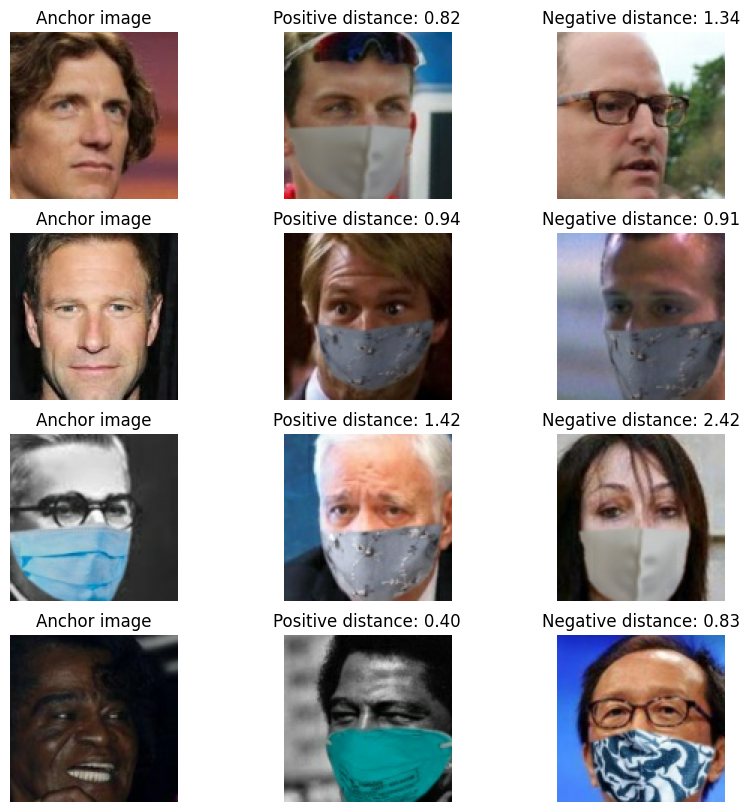

In [18]:
test_ds = tf.data.Dataset.from_generator(
	generator=img_generator,
	output_signature=(  tf.TensorSpec(shape=(), dtype=tf.string),
	                	tf.TensorSpec(shape=(), dtype=tf.string),
		                tf.TensorSpec(shape=(), dtype=tf.string),))

mapFunction = MapFunction(imageSize=(112,112))

testDs = (test_ds
	.map(mapFunction)
	.batch(8)
	.prefetch(tf.data.AUTOTUNE)
)

modelPath = "/content/"
triplet_network = keras.models.load_model(filepath=modelPath)
tri_model = Triplet_model(triplet_network, 0.5, keras.metrics.Mean(name="loss"))

# load the test data
(anchor, positive, negative) = next(iter(testDs))
(apDistance, anDistance) = tri_model((anchor, positive, negative))
plt.figure(figsize=(10, 10))
rows = 4
for row in range(rows):
	plt.subplot(rows, 3, row * 3 + 1)
	plt.imshow(anchor[row])
	plt.axis("off")
	plt.title("Anchor image")
	plt.subplot(rows, 3, row * 3 + 2)
	plt.imshow(positive[row])
	plt.axis("off")
	plt.title(f"Positive distance: {apDistance[row]:0.2f}")
	plt.subplot(rows, 3, row * 3 + 3)
	plt.imshow(negative[row])
	plt.axis("off")
	plt.title(f"Negative distance: {anDistance[row]:0.2f}")
